## Chroma multi-modal RAG

Many documents contain a mixture of content types, including text and images. 

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:` (Shown) 

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

`Option 2:` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

`Option 3` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image 
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

This cookbook highlights `Option 1`: 

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use Open Clip multi-modal embeddings.
* We will use [Chroma](https://www.trychroma.com/) with support for multi-modal.

A seperate cookbook highlights `Options 2 and 3` [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/multi_modal_RAG.ipynb).

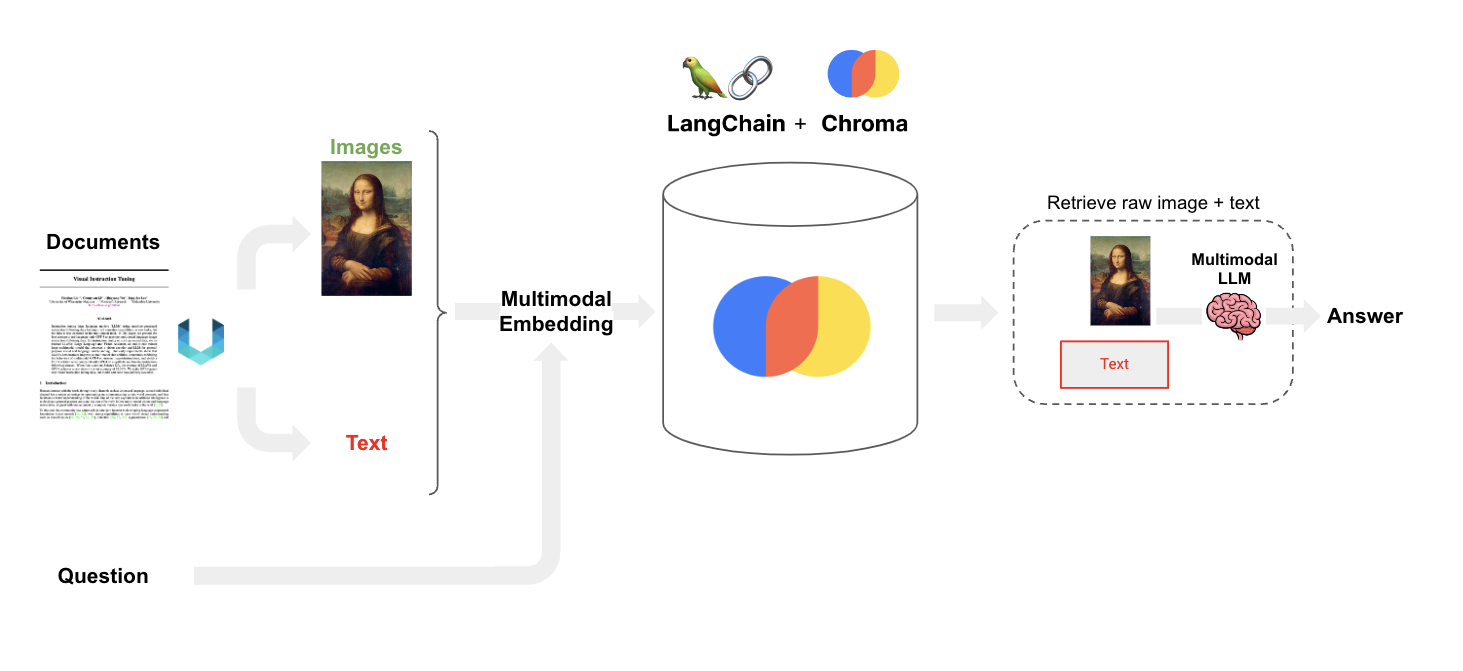

## Packages

For `unstructured`, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [ ]:
! pip install "langchain==0.0.331rc2" # (required for multi-modal)
! pip install "openai==1.1.1" # (required for multi-modal)
! pip install "chromadb==0.4.16" # (required for multi-modal)

In [ ]:
! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

## Data Loading

### Partition PDF text and images
  
Let's look at an example pdf of classical [Art](https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf) from the J Paul Getty museum.

There are two ways to access it:

1) Download the pdf and run the `partition_pdf` below.
2) Download the zip file [here](https://drive.google.com/file/d/18kRKbq2dqAhhJ3DfZRnYcTBEUfYxe1YR/view?usp=sharing) with the PDF and the extracted images. In this case, simply load the PDF (e.g., with [PyPDF](https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf) and [split](https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/recursive_text_splitter) to `texts`).

In [4]:
# Folder with pdf and extracted images 
path = "/Users/rlm/Desktop/art/"

In [ ]:
# Extract images, tables, and chunk text
from unstructured.partition.pdf import partition_pdf
raw_pdf_elements = partition_pdf(
    filename=path + "getty.pdf",
    extract_images_in_pdf=False, 
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

In [6]:
# Categorize by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

## Multi-modal embeddings with our document

We will use [OpenClip multimodal embeddings](https://python.langchain.com/docs/integrations/text_embedding/open_clip).

We use a larger model for better performance (set in `langchain_experimental.open_clip.py`).

```
model_name = "ViT-g-14"
checkpoint = "laion2b_s34b_b88k"
```

In [7]:
import os
import uuid
import chromadb
import numpy as np
from PIL import Image as _PILImage
from langchain.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings

# Create chroma
vectorstore = Chroma(
    collection_name="mm_rag_test",
    embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs with .jpg extension only
image_uris = sorted([os.path.join(path, image_name) 
                     for image_name in os.listdir(path) 
                     if image_name.endswith('.jpg')])

# Add images
vectorstore.add_images(uris=image_uris)

# Add documents
vectorstore.add_texts(texts=texts)

# Make retriever 
retriever = vectorstore.as_retriever()

## RAG

`vectorstore.add_images` will store / retrieve images as base64 encoded strings.

These can be passed to [GPT-4V](https://platform.openai.com/docs/guides/vision).

In [9]:
import numpy as np
import base64
from io import BytesIO
from PIL import Image

def is_base64(s):
    ''' Check if a string is Base64 encoded '''
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False
        
def split_image_text_types(docs):
    ''' Split numpy array images and texts '''
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content # Extract Document contents 
        if is_base64(doc):
            images.append(doc)  # base64 encoded str 
        else:
            text.append(doc) 
    return {
        "images": images,
        "texts": text
    }

Currently, we format the inputs using a `RunnableLambda` while we add image support to `ChatPromptTemplates`.

Our runnable follows the classic RAG flow - 

* We first compute the context (both "texts" and "images" in this case) and the question (just a RunnablePassthrough here) 
* Then we pass this into our prompt template, which is a custom function that formats the message for the gpt-4-vision-preview model. 
* And finally we parse the output as a string.

In [42]:
from operator import itemgetter
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.schema.messages import HumanMessage, SystemMessage

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    messages = [
        {"type": "text", "text": f"""You are an art critic. Descrive and discuss art using following context, which can include text and the below image:
Question: {dict["question"]}

Text and tables:
{format_texts}
"""}]

    if dict["context"]["images"]:  # Check if there are any images
        image_message = {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}}
        messages.append(image_message)

    return [HumanMessage(content=messages)]
    
model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = (
    {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

## Test retrieval anmd run RAG

18

personality and artistic interests, but he was most famous as a landscape painter.

MARCO  RICCI Venice, 1676-1730 Landscape  with Ruins and Figures oil on canvas, 123 x 161 cm 19  Marco Ricci was primarily a landscape painter. He did not depict  his home city of Venice in his compositions, but  usually the open countryside, often  under stormy conditions. Late in his life, during the  17205, he came to specialize in scenes with classical ruins, and these ruins were often from  the city of Rome. The present view is imaginary and includes a wide variety of structures and monuments that could have been seen in Rome, but  not on the same site. He has shown them in a romanticized rather than a topographical manner, evoking a kind of nostalgia with his use of shadows, trees, changing color, and pinkish clouds. The figures, which are perhaps by his uncle, Sebastiano, are meant only to lend scale to this faded world.

19

Sebastiano, are meant only to lend scale to this faded world.

Marc


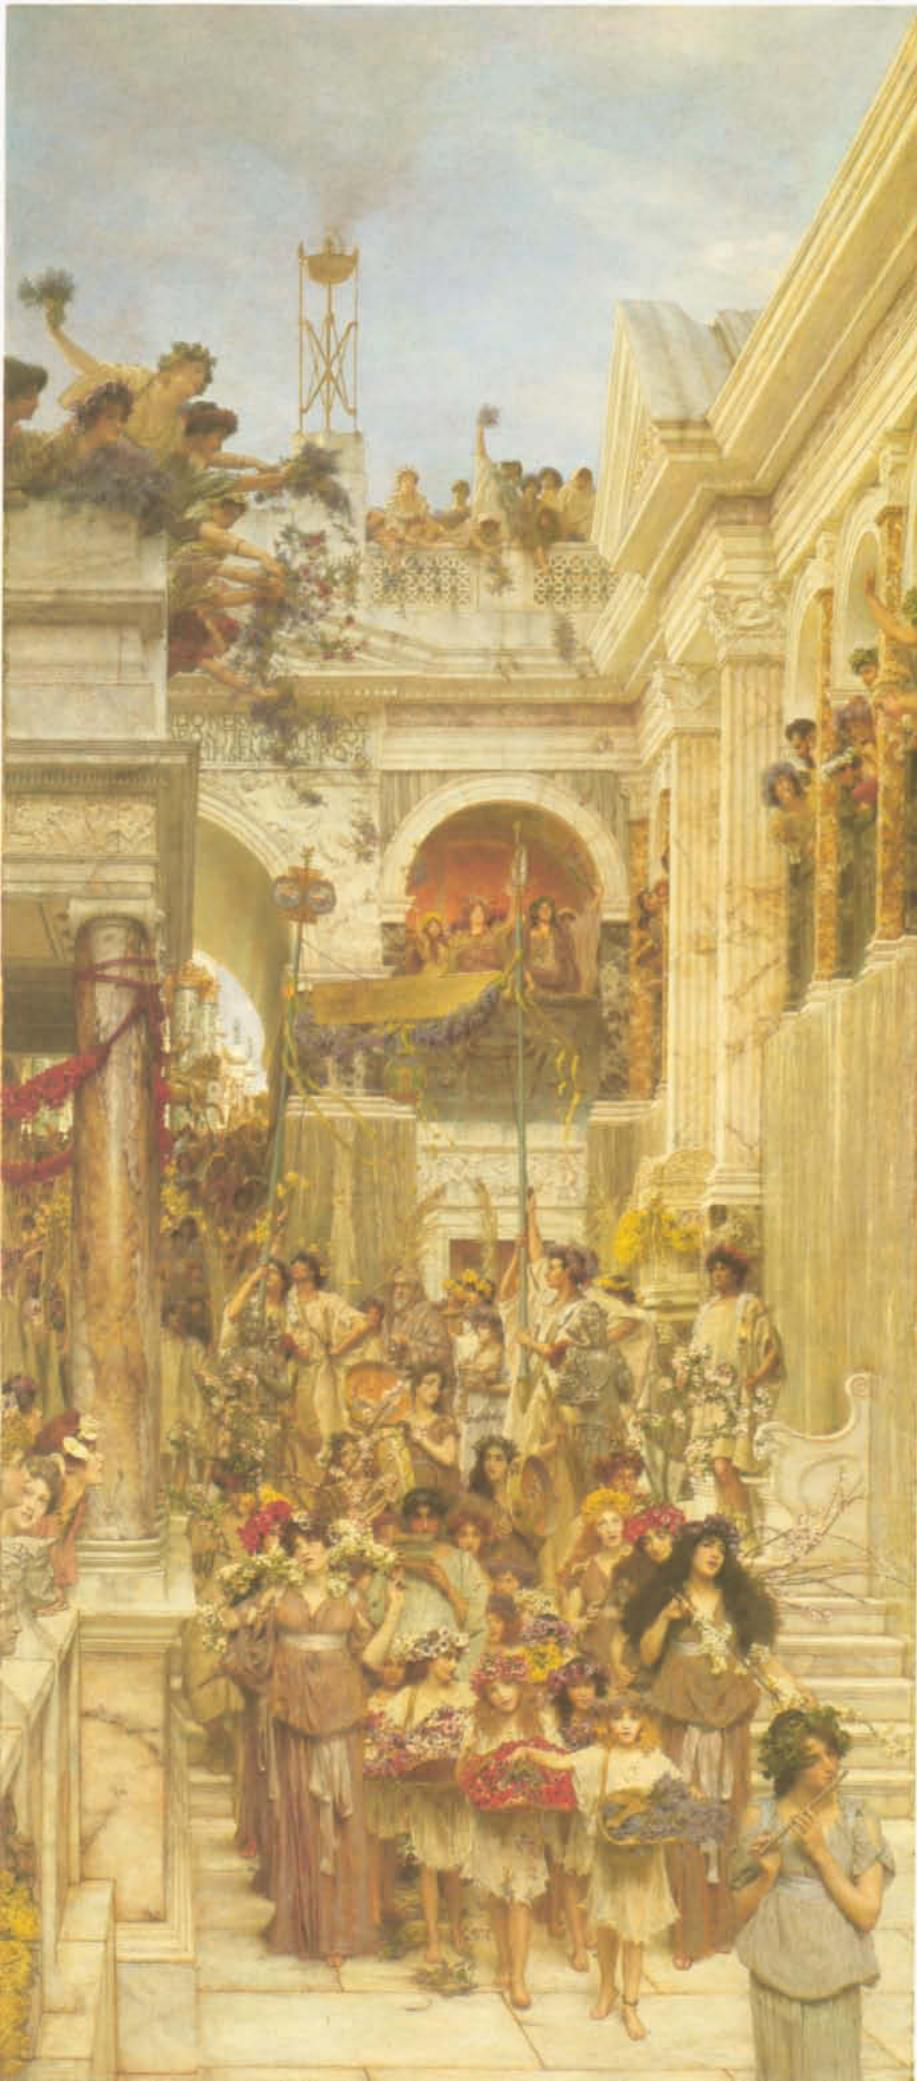

Flemish, 1488-1541

20

When Italian artists of the Renaissance came into contact with paintings from the north, they

ANTHONIS MOR Flemish, 1517-1577 Portrait  of a Man  in Armor oil on canvas, 112x89 cm 27  Mor, who was a native of Utrecht, enjoyed widespread recognition throughout the Hapsburg empire as the court portrait painter. He worked for the emperors Charles V and Philip II in a variety of cities, including Madrid, Rome, London, and Brussels. His style derived  from  that of Titian who first made poses such as this popular, and the tradition continued well into the next century before it was substantially altered. The  sitter, is normally shown to the waist, or a bit below, from  a three-quarter  position,  and formally attired. He always fixes the viewer with his gaze. One is meant to sense the importance of the sitters, but  at the hands of an artist with the ability of Mor, some of their humanity also comes through. The  subject of our painting,  though unknown, may have b

In [12]:
from IPython.display import display, HTML

def plt_img_base64(img_base64):

    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    
    # Display the image by rendering the HTML
    display(HTML(image_html))
    
docs = retriever.get_relevant_documents("Art featuring a Romain scene, arches",k=5)
for doc in docs:
    if is_base64(doc.page_content):
        plt_img_base64(doc.page_content)
    else:
        print(doc.page_content)

Run RAG

In [43]:
chain.invoke(
    "Art featuring a Romain scene, arches"
)

"The image presented here is a rich tapestry of classical Roman life, depicted with a romanticized vision that is characteristic of certain artistic periods that sought to evoke the grandeur and beauty of antiquity. The scene is bustling with activity, as figures adorned with floral wreaths and garlands engage in what appears to be a festive procession or celebration. The architecture surrounding them is replete with classical Roman elements, including arches, columns, and intricate friezes, which lend an air of authenticity and historical context to the composition.\n\nThe artist has skillfully employed a soft, diffused light that bathes the scene in a warm, golden hue, suggesting the glow of late afternoon. This lighting choice enhances the sense of nostalgia and romanticism that pervades the work. The use of shadows and the varying intensity of light and color across the canvas create a dynamic and engaging visual experience, drawing the viewer's eye through the different levels of 

We can see the images retrieved in the LangSmith trace:

LangSmith [trace](https://smith.langchain.com/public/e0b03a98-e859-48ff-8aee-761c27bd987a/r).

In [85]:
chain.invoke(
    "War"
)

"The image you've provided appears to be a historical painting depicting a scene that could be interpreted as a moment of truce or negotiation during a time of conflict. The central figures are engaged in a handshake, which is often a symbol of agreement or peace. The presence of military attire, such as armor and weapons, suggests that the individuals are of high rank and possibly commanders or nobility who have the authority to negotiate terms.\n\nThe painting is executed with a focus on realism, capturing the textures of the fabrics, the shine of the armor, and the individual expressions of the characters. The use of chiaroscuro, the contrast between light and dark, adds depth to the scene and highlights the central action of the handshake. The background is less detailed, which is typical of many historical paintings, where the emphasis is on the subjects and their interactions rather than the setting.\n\nIn the context of war, this painting could be seen as a representation of the

We can see the images retrieved in the LangSmith trace:

LangSmith [trace](https://smith.langchain.com/public/a7c45b37-0576-47c3-beeb-7b2cb610a51b/r)